# Previsão de fakenews utilizando Naive Bayers 

### Discente(s):  

Joana D'arc,  
Erick Vinicius Rebouças Cruz,  
Paulo Vitor Barbosa Santana,   
Eliezer Martins de Oliveira,  


### Framework:  
TensorFlow/Keras

### Requerimentos:
1. Python 3.9
2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
3. Pandas
4. Matplotlib
5. Sklearn
6. Numpy
7. Dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset  

Etapas do Projeto:
1. Carregamento e Exploração dos Dados
2. Pré-processamento
3. Analisando dados encontrados
4. Criação do Naive Bayers  
5. Treinamento e Validação do Modelo
6. Avaliação e Previsões  

In [58]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, f1_score, fbeta_score, log_loss


from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 


In [4]:
# Carregamento dos dados falsos
data_fake = pd.read_csv('data/Fake.csv')
data_fake["date"] = pd.to_datetime(data_fake["date"], errors='coerce')
print(data_fake.shape)
data_fake.head()


(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25


In [5]:
# Carregamento dos dados verdadeiros
data_true = pd.read_csv('data/True.csv')
data_true["date"] = pd.to_datetime(data_true["date"], errors='coerce')
print(data_true.shape)
data_true.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29


In [6]:
data_true['label'] = 0
data_fake['label'] = 1

In [7]:
#df = pd.concat([data_true, data_fake])

df = pd.concat([data_true, data_fake]).sample(frac=1)  # Embaralha durante a concatenação
df["Article"] = df["title"] + " " + df["text"]

In [8]:
df['subject']

21639       left-news
16256       worldnews
20665       left-news
4824     politicsNews
13252       worldnews
             ...     
17996       worldnews
4692             News
12975       worldnews
1791             News
7196             News
Name: subject, Length: 44898, dtype: object

In [9]:
import re
import nltk
# Caso ainda não tenha os stopwords baixados
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def clean_text(text):
    # Coloca o texto em minúsculas
    text = text.lower()
    # Remove caracteres que não sejam letras e espaços
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove palavras irrelevantes (stopwords)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Aplica a limpeza do texto
df["Article_clean"] = df["Article"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yienvee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analise Exploratoria dos Dados (EAD)

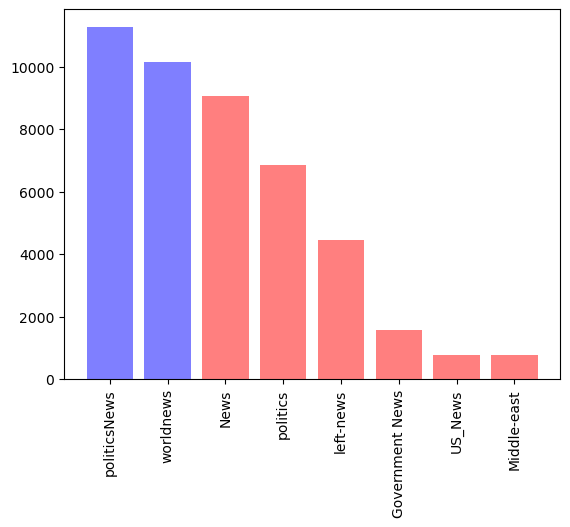

<Figure size 1200x600 with 0 Axes>

In [10]:
plt.bar(data_true['subject'].value_counts().index, data_true['subject'].value_counts().values, color='blue', alpha=0.5)
plt.bar(data_fake['subject'].value_counts().index, data_fake['subject'].value_counts().values, color='red', alpha=0.5)
plt.xticks(rotation=90)
plt.figure(figsize=(12, 6))
plt.show()

In [11]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label', 'Article',
       'Article_clean'],
      dtype='object')

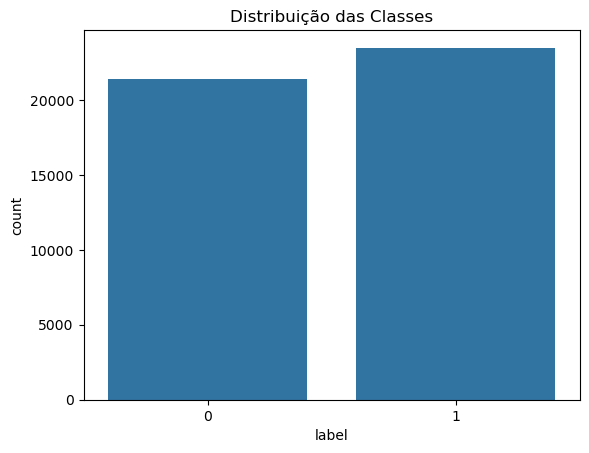

label
1    0.522985
0    0.477015
Name: proportion, dtype: float64


In [12]:


# Contagem de cada classe
sns.countplot(x=df['label'])
plt.title("Distribuição das Classes")
plt.show()

# Proporção das classes
print(df['label'].value_counts(normalize=True))


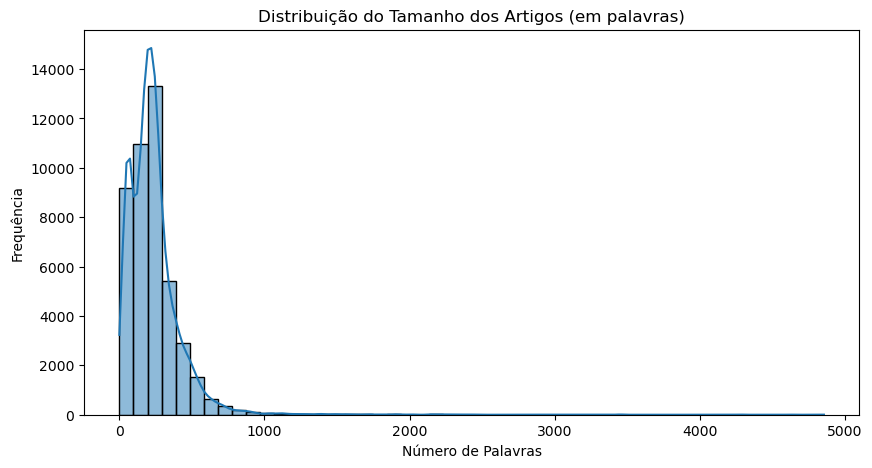

In [13]:
df["text_length"] = df["Article_clean"].apply(lambda x: len(x.split()))

# Histograma do comprimento dos textos
plt.figure(figsize=(10,5))
sns.histplot(df["text_length"], bins=50, kde=True)
plt.title("Distribuição do Tamanho dos Artigos (em palavras)")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()


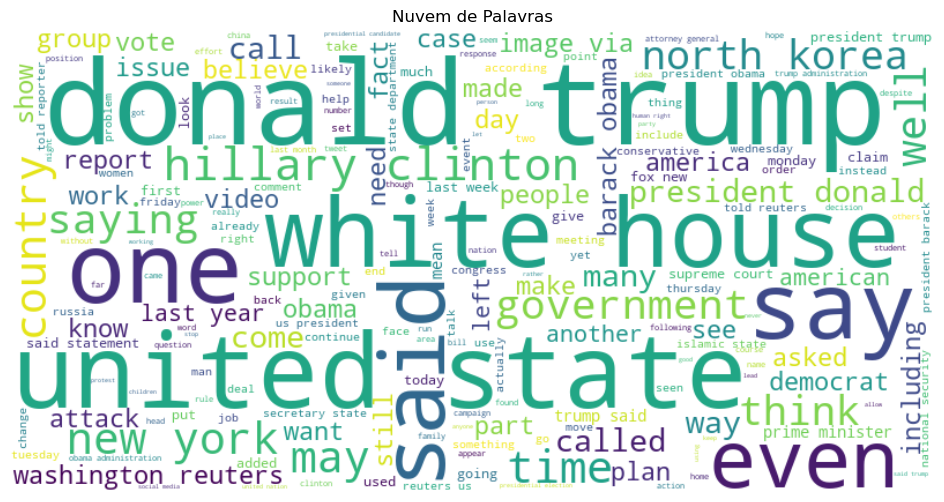

In [15]:
from wordcloud import WordCloud

# Juntar todos os textos
all_text = " ".join(df["Article_clean"])

# Gerar word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plotar a word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()


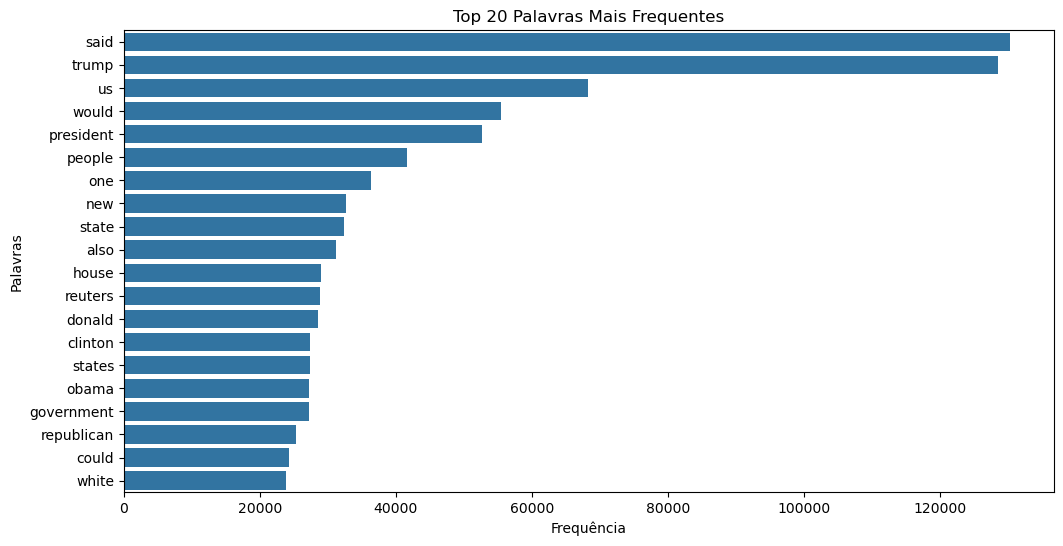

In [16]:
from collections import Counter

# Contar frequência de palavras
word_counts = Counter(all_text.split())

# Criar um DataFrame com as palavras mais frequentes
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)



# Gráfico das palavras mais frequentes
plt.figure(figsize=(12, 6))
sns.barplot(x=word_freq_df["count"][:20], y=word_freq_df["word"][:20])
plt.title("Top 20 Palavras Mais Frequentes")
plt.xlabel("Frequência")
plt.ylabel("Palavras")
plt.show()


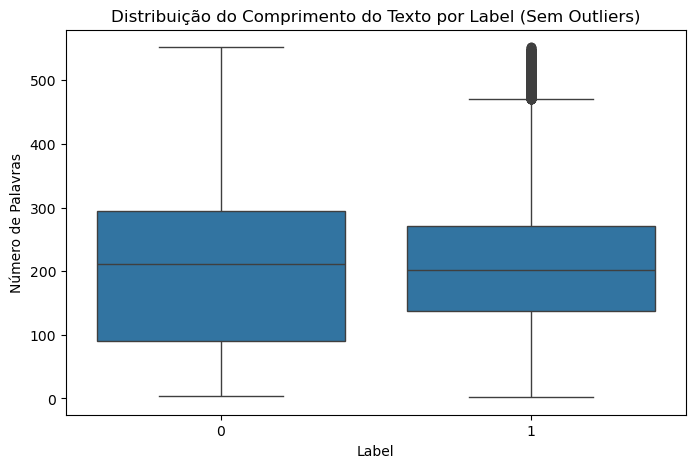

In [17]:

# Calcular Q1, Q3 e IQR
Q1 = np.percentile(df["text_length"], 25)
Q3 = np.percentile(df["text_length"], 75)
IQR = Q3 - Q1

# Definir limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar os dados removendo os outliers
df_filtered = df[(df["text_length"] >= lower_bound) & (df["text_length"] <= upper_bound)]

# Plotar boxplot sem outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_filtered["label"], y=df_filtered["text_length"])
plt.title("Distribuição do Comprimento do Texto por Label (Sem Outliers)")
plt.xlabel("Label")
plt.ylabel("Número de Palavras")
plt.show()



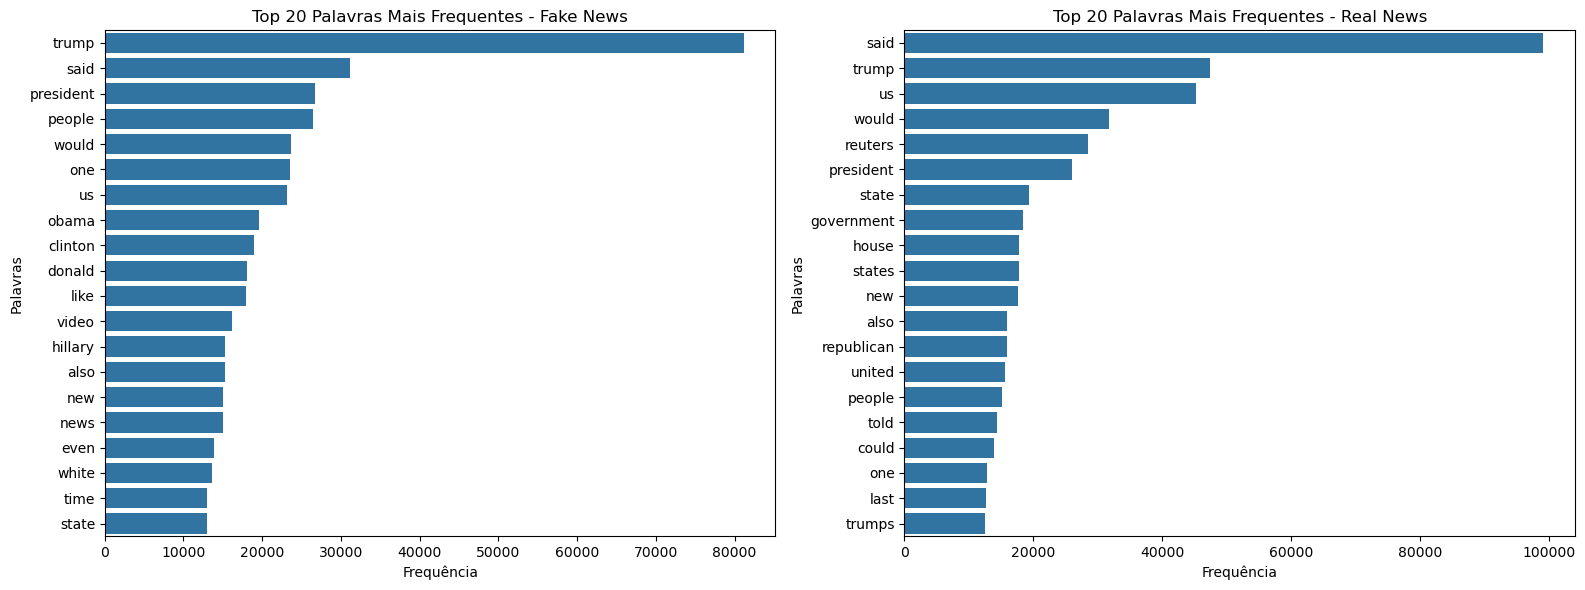

In [18]:
# Separar artigos falsos e verdadeiros
fake_articles = " ".join(df[df["label"] == 1]["Article_clean"])
real_articles = " ".join(df[df["label"] == 0]["Article_clean"])

# Contar frequência de palavras para cada categoria
fake_word_counts = Counter(fake_articles.split())
real_word_counts = Counter(real_articles.split())

# Criar DataFrames com as palavras mais frequentes
fake_word_freq_df = pd.DataFrame(fake_word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)
real_word_freq_df = pd.DataFrame(real_word_counts.items(), columns=["word", "count"]).sort_values(by="count", ascending=False)


# Criar gráficos para cada categoria
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=fake_word_freq_df["count"][:20], y=fake_word_freq_df["word"][:20], ax=axes[0])
axes[0].set_title("Top 20 Palavras Mais Frequentes - Fake News")
axes[0].set_xlabel("Frequência")
axes[0].set_ylabel("Palavras")

sns.barplot(x=real_word_freq_df["count"][:20], y=real_word_freq_df["word"][:20], ax=axes[1])
axes[1].set_title("Top 20 Palavras Mais Frequentes - Real News")
axes[1].set_xlabel("Frequência")
axes[1].set_ylabel("Palavras")

plt.tight_layout()
plt.show()



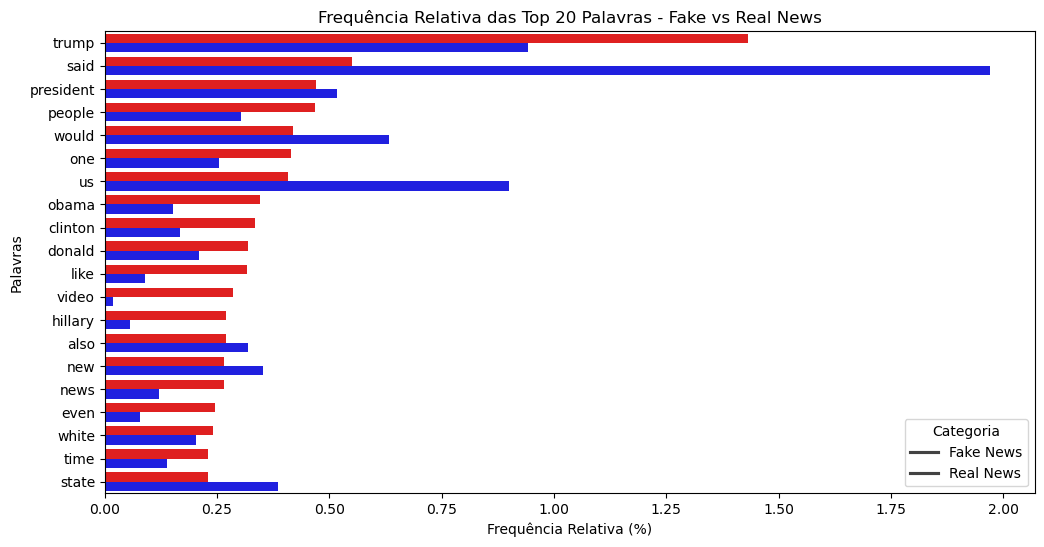

In [ ]:
# Juntar os artigos fake e real em strings únicas
fake_articles = " ".join(df[df["label"] == 1]["Article_clean"])
real_articles = " ".join(df[df["label"] == 0]["Article_clean"])

# Contar as palavras
fake_word_counts = Counter(fake_articles.split())
real_word_counts = Counter(real_articles.split())

# Calcular o total de palavras
total_fake_words = sum(fake_word_counts.values())
total_real_words = sum(real_word_counts.values())

# Criar DataFrames de frequência relativa
fake_word_freq_df = pd.DataFrame({
    "word": list(fake_word_counts.keys()),
    "relative_freq": [count / total_fake_words * 100 for count in fake_word_counts.values()]
}).sort_values(by="relative_freq", ascending=False)

real_word_freq_df = pd.DataFrame({
    "word": list(real_word_counts.keys()),
    "relative_freq": [count / total_real_words * 100 for count in real_word_counts.values()]
}).sort_values(by="relative_freq", ascending=False)

# Merge dos DataFrames para ter as frequências de cada palavra em ambos os conjuntos
merged_freq = pd.merge(fake_word_freq_df, real_word_freq_df, on="word", suffixes=("_fake", "_real"))

# Selecionar as 20 palavras com maior frequência em fake news
top_words = merged_freq.nlargest(20, "relative_freq_fake")

# Visualizar usando um gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_words.melt(id_vars="word", var_name="category", value_name="percentage"),
    x="percentage", y="word", hue="category", palette=["red", "blue"]
)
plt.title("Frequência Relativa das Top 20 Palavras - Fake vs Real News")
plt.xlabel("Frequência Relativa (%)")
plt.ylabel("Palavras")
plt.legend(title="Categoria", labels=["Fake News", "Real News"])
plt.show()


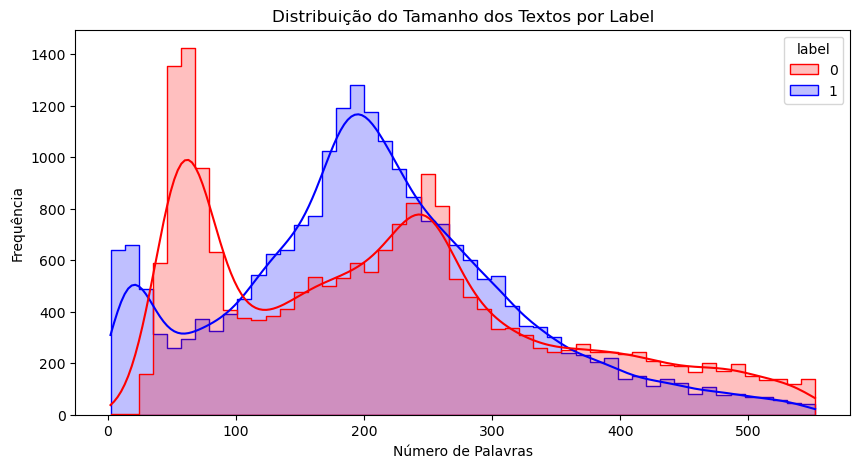

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df_filtered, x="text_length", hue="label", bins=50, kde=True, element="step", palette=["red", "blue"])
plt.title("Distribuição do Tamanho dos Textos por Label")
plt.xlabel("Número de Palavras")
plt.ylabel("Frequência")
plt.show()


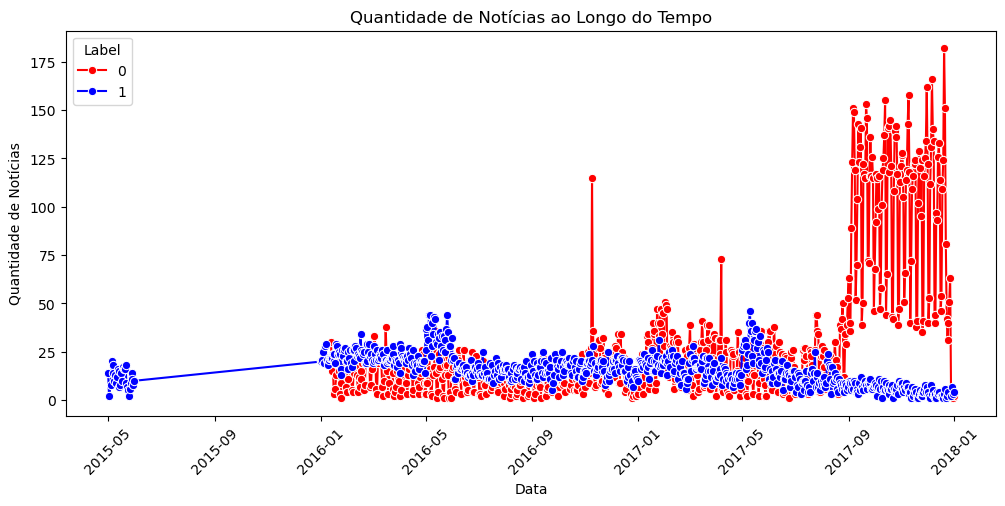

In [ ]:
# Contar notícias por data e label
df_date_counts = df.groupby(["date", "label"]).size().reset_index(name="count")

# Criar a figura
plt.figure(figsize=(12, 5))

# Plotar tendência temporal para cada label
sns.lineplot(data=df_date_counts, x="date", y="count", hue="label", marker="o", palette={0: "red", 1: "blue"})

plt.title("Quantidade de Notícias ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Quantidade de Notícias")
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.show()

# Tokenização para o treino

In [ ]:
# Tokenização: converte os textos em uma matriz de contagem de termos
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["Article_clean"])
y = df["label"]

# Divisão de dados e treinamento com Naive Bayes

In [33]:
# Divide os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Complement Naive Bayes


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4305
           1       0.97      0.95      0.96      4675

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980


Acurácia: 0.9590200445434298
Precision (ComplementNB): 0.9678470562676516
AUC-ROC: 0.9821292241952213
AUC-PR: 0.984154076581438


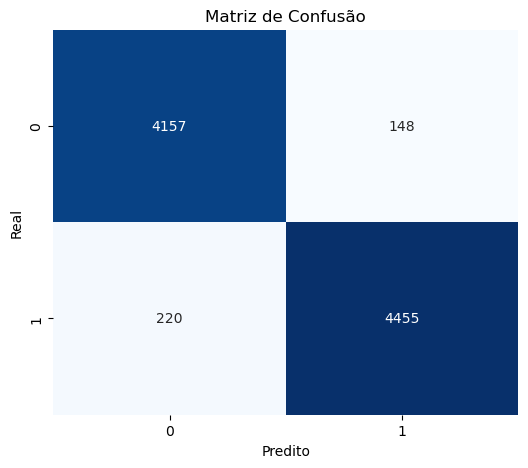

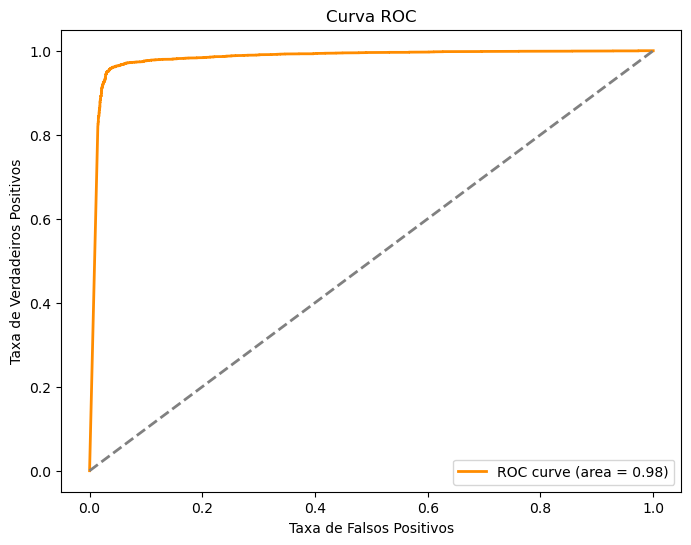

In [64]:
# Criação e treinamento do classificador Naive Bayes (utilizando ComplementNB)
comp = ComplementNB()
comp.fit(X_train, y_train)

# Realiza predições para os dados de teste
y_pred_comp = comp.predict(X_test)


print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_comp))
comp_acc = accuracy_score(y_test, y_pred_comp)
print("\nAcurácia:", comp_acc)
# Para o classificador ComplementNB
precision = precision_score(y_test, y_pred_comp, average='binary')
print("Precision (ComplementNB):", precision)


y_probs_comp = comp.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
roc_auc_comp = roc_auc_score(y_test, y_probs_comp)
print("AUC-ROC:", roc_auc_comp)
precision, recall, _ = precision_recall_curve(y_test, y_probs_comp)
pr_auc = auc(recall, precision)
print("AUC-PR:", pr_auc)
cm = confusion_matrix(y_test, y_pred_comp)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_probs_comp)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_comp:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


# Multinomial Naive Bayes


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4305
           1       0.97      0.95      0.96      4675

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980


Acurácia: 0.9593541202672605
Precision (MultinomialNB): 0.9678679982631351
AUC-ROC: 0.9821259199910563
AUC-PR: 0.9841470060001428


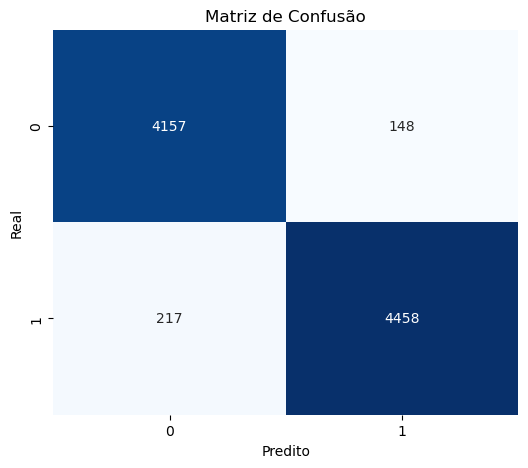

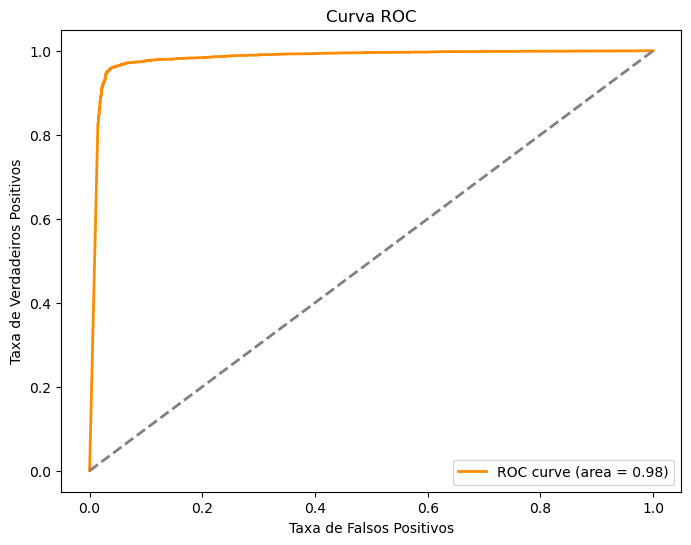

In [63]:
mltn = MultinomialNB()
mltn.fit(X_train, y_train)

y_pred_mltn = mltn.predict(X_test)


print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_mltn))

mltn_acc = accuracy_score(y_test, y_pred_mltn)
print("\nAcurácia:", mltn_acc)

precision_multinomial = precision_score(y_test, mltn.predict(X_test))
print("Precision (MultinomialNB):", precision_multinomial)

y_probs_mltn = mltn.predict_proba(X_test)[:, 1]
roc_auc_mltn = roc_auc_score(y_test, y_probs_mltn)
print("AUC-ROC:", roc_auc_mltn)
precision, recall, _ = precision_recall_curve(y_test, y_probs_mltn)
pr_auc = auc(recall, precision)
print("AUC-PR:", pr_auc)

cm = confusion_matrix(y_test, y_pred_mltn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
fpr, tpr, thresholds = roc_curve(y_test, y_probs_mltn)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_mltn:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()